In [2]:
import geopandas as gpd
import fiona
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

# Reading the Data

This notebook contains a few cells, testing GeoPandas functions using the data and then setting my bird species data to a single file for each relevant emissions scenario, for ease of future use.

## Example Mapping

A basic test of functionality: how will all this work?

In [3]:
# just how many bid species are we working with?
len(os.listdir('./bird-species/'))

616

In [4]:
# first species file (or directory?) I came across, as an example.
# reading in the data:
bbw_duck = gpd.read_file('./bird-species/E00021500_black_bellied_whistling_duck.gdb/')

In [5]:
bbw_duck

,value,Shape_Length,Shape_Area,geometry
0,1.0,5540000.0,1.488000e+11,"(POLYGON ((-124911.2311000004 -1575519.5457, -..."


In [6]:
# checking the column information
bbw_duck.columns

Index(['value', 'Shape_Length', 'Shape_Area', 'geometry'], dtype='object')

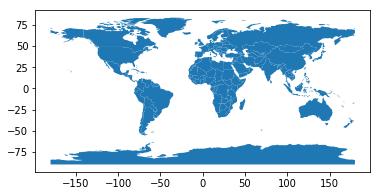

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

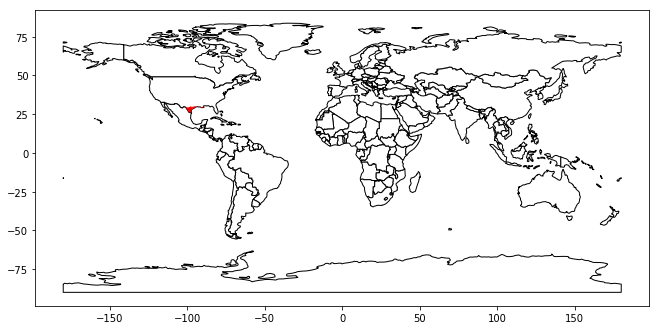

In [8]:
# looking around the GeoPandas documentaion, this map of Earth seems to be the only
# map included in the module. That's a shame, since all the data relates to the Americas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# making sure the coordinates line up:
bbw_duck = bbw_duck.to_crs(world.crs)

#establishing figure axes
base = world.plot(color='white', edgecolor='black',figsize=(11,11))

bbw_duck.plot(ax=base, color='red');

In [9]:
# A very useful cell. Sometimes this file doesn't read in correctly. If this cell
# gives {} as the answer, try restarting everything and running it again.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs

{'init': 'epsg:4326'}

### Examining Map Layers

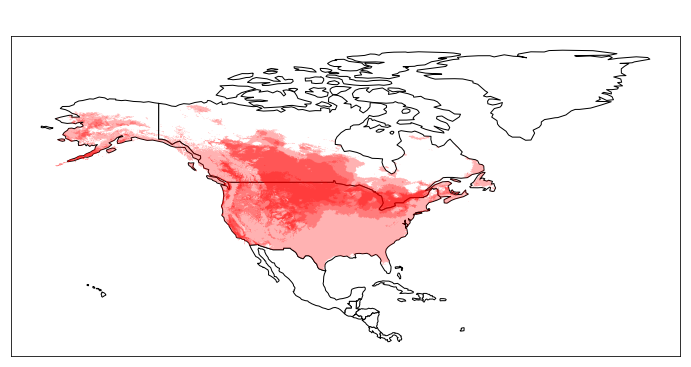

In [10]:
# geopandas included map, filtered to just North America
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
westhem = world[(world['continent'] == 'North America')]
base = westhem.plot(color='white', edgecolor='black', figsize=(12,12))

# mapping all the layers for a single species, mainly to test mapping with layer sorting
plt.title("Mallard Range and Predictions",fontsize=30,color='white')
plt.axis('tight')
plt.xticks([])
plt.yticks([])
layers = fiona.listlayers('./bird-species/E00039600_mallard.gdb')

# for this species, these are the layers I'll be examining in future project stages
for l in [0,2,5,8]:
    mallard = gpd.read_file('./bird-species/E00039600_mallard.gdb', layer=layers[l])
    mallard = mallard.to_crs({'init': 'epsg:4326'})
    mallard.plot(ax=base, color='red', alpha=.3)

In [11]:
mal0 = gpd.read_file('./bird-species/E00039600_mallard.gdb', layer=0)
mal0.columns

Index(['value', 'Shape_Length', 'Shape_Area', 'geometry'], dtype='object')

In [12]:
layers = fiona.listlayers('./bird-species/E00021700_fulvous_whistling_duck.gdb/')
fw_duck = gpd.GeoDataFrame()
for l in [0,2,5,8]:
    row = gpd.read_file('./bird-species/E00021700_fulvous_whistling_duck.gdb/',
                        layer=layers[l])
    fw_duck = gpd.GeoDataFrame(pd.concat([fw_duck,row], ignore_index=True))
fw_duck


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,FUWD_2020_,FUWD_2050_,FUWD_2080_,SP_ID,Shape_Area,Shape_Length,geometry,value
0,NaN,NaN,NaN,NaN,3.230000e+10,4040000.0,"(POLYGON ((-194911.2311000004 -1615519.5457, -...",1.0
1,1.0,NaN,NaN,1,8.670000e+10,6280000.0,"(POLYGON ((-194911.2311000004 -1615519.5457, -...",NaN
2,NaN,1.0,NaN,1,1.395000e+11,9460000.0,"(POLYGON ((-194911.2311000004 -1615519.5457, -...",NaN
3,NaN,NaN,1.0,1,3.134000e+11,19080000.0,"(POLYGON ((-124911.2311000004 -1575519.5457, -...",NaN


In [13]:
layers

['E00021700_fuwduc_2000_suitability_kappa_BBS',
 'E00021700_fuwduc_2020_A1B_suitability_kappa_BBS',
 'E00021700_fuwduc_2020_A2_suitability_kappa_BBS',
 'E00021700_fuwduc_2020_B2_suitability_kappa_BBS',
 'E00021700_fuwduc_2050_A1B_suitability_kappa_BBS',
 'E00021700_fuwduc_2050_A2_suitability_kappa_BBS',
 'E00021700_fuwduc_2050_B2_suitability_kappa_BBS',
 'E00021700_fuwduc_2080_A1B_suitability_kappa_BBS',
 'E00021700_fuwduc_2080_A2_suitability_kappa_BBS',
 'E00021700_fuwduc_2080_B2_suitability_kappa_BBS']

## Establishing Layers

Here I set up the list of layers I will be using. I decided to look at the A2 emissions scenario. While it's not quite the most extreme, it will show a lot of change and seems more reasonable to me than some of the other, more optimistic scenarios.

In [10]:
keep_layers = [
    '2000_suitability_kappa_BBS',
    '2020_A2_suitability_kappa_BBS',
    '2050_A2_suitability_kappa_BBS',
    '2080_A2_suitability_kappa_BBS',
    '2000_suitability_kappa_CBC',
    '2020_A2_suitability_kappa_CBC',
    '2050_A2_suitability_kappa_CBC',
    '2080_A2_suitability_kappa_CBC'
]

## Data Aggregation

Saving the data into one big GeoDataFrame

### Warning

This cell has a long run time (measured in hours). If you are looking to reproduce these results, you may want to track the print the statements for a bit, then interrupt and use the files already stored in the repository.

In [13]:
# the goal here is to save each climate projection/study in the A2 scenario into its own
# GeoDataFrame. Then, in another notebook I can deal with turning each study into an
# aggregate map.

# for each target study
for layer in keep_layers:
    print(f'For layer: {layer}')
    gdf = gpd.GeoDataFrame()
    # check each bird if it has that layer
    for file in os.listdir('./bird-species/'):
        # some files aren't formatted properly, or weren't downloaded properly
        try:
            # check each layer in that bird if it's the right one
            bird_layers = fiona.listlayers(f'./bird-species/{file}')
            for bl in bird_layers:
                if layer in bl:
                    # if layers match, add that as a row to our output GeoDataFrame
                    row = gpd.read_file(f'./bird-species/{file}',layer = bl)
                    gdf = gpd.GeoDataFrame(pd.concat([gdf,row], ignore_index=True))
            print(f'{file} added to GeoDataFrame')
        except:
            print(f'{file} had an error')
    print("----------")
                
    #and save the GeoDataFrame
    gdf.to_file(f'./birds-data/{layer}')

For layer: 2000_suitability_kappa_BBS
E03036900_tricolored_blackbird.gdb added to GeoDataFrame
E03102100_pine_siskin.gdb added to GeoDataFrame
E00407805_semipalmated_sandpiper.gdb added to GeoDataFrame
E02786000_hooded_warbler.gdb added to GeoDataFrame
E01505600_gray_kingbird.gdb added to GeoDataFrame
E00752100_spotted_owl.gdb added to GeoDataFrame
E01997200_tree_swallow.gdb added to GeoDataFrame
E01119400_american_three_toed_woodpecker.gdb added to GeoDataFrame
E00392100_killdeer.gdb added to GeoDataFrame
E02994600_white_crowned_sparrow.gdb added to GeoDataFrame
E02786500_northern_parula.gdb added to GeoDataFrame
E00297400_gray_hawk.gdb added to GeoDataFrame
E03032800_varied_bunting.gdb added to GeoDataFrame
E00432000_western_gull.gdb added to GeoDataFrame
E00055500_common_merganser.gdb added to GeoDataFrame
E03016300_scarlet_tanager.gdb added to GeoDataFrame
E01778600_gray_vireo.gdb added to GeoDataFrame
E00206900_american_white_pelican.gdb added to GeoDataFrame
E00361500_american_co

E03042100_common_grackle.gdb added to GeoDataFrame
E03140300_eurasian_tree_sparrow.gdb added to GeoDataFrame
E00432800_herring_gull.gdb added to GeoDataFrame
E02493300_varied_thrush.gdb added to GeoDataFrame
E03083400_black_rosy_finch.gdb added to GeoDataFrame
E03134500_house_sparrow.gdb added to GeoDataFrame
E02113800_house_wren.gdb added to GeoDataFrame
E01883700_florida_scrub_jay.gdb added to GeoDataFrame
E00940200_elegant_trogon.gdb added to GeoDataFrame
E00077500_scaled_quail.gdb added to GeoDataFrame
E01907300_american_crow.gdb added to GeoDataFrame
E00154800_greater_prairie_chicken.gdb added to GeoDataFrame
E00834500_white_throated_swift.gdb added to GeoDataFrame
E00392450_mountain_plover.gdb added to GeoDataFrame
E02786400_cerulean_warbler.gdb added to GeoDataFrame
E02047000_bridled_titmouse.gdb added to GeoDataFrame
E01458800_least_flycatcher.gdb added to GeoDataFrame
E00160100_pied_billed_grebe.gdb added to GeoDataFrame
E00445600_gull_billed_tern.gdb added to GeoDataFrame
E02

E00402300_ruddy_turnstone.gdb added to GeoDataFrame
E00737500_ferruginous_pygmy_owl.gdb added to GeoDataFrame
E00733400_northern_hawk_owl.gdb added to GeoDataFrame
E00239100_white_tailed_kite.gdb added to GeoDataFrame
E02459200_veery.gdb added to GeoDataFrame
E01158283_prairie_falcon.gdb added to GeoDataFrame
E02972600_field_sparrow.gdb added to GeoDataFrame
E00408000_short_billed_dowitcher.gdb added to GeoDataFrame
E02027500_chestnut_backed_chickadee.gdb added to GeoDataFrame
E02797600_golden_cheeked_warbler.gdb added to GeoDataFrame
E03087840_purple_finch.gdb added to GeoDataFrame
E02813800_yellow_breasted_chat.gdb added to GeoDataFrame
E00293400_harriss_hawk.gdb added to GeoDataFrame
E00508300_white_tipped_dove.gdb added to GeoDataFrame
E02012800_cave_swallow.gdb added to GeoDataFrame
E00049900_ring_necked_duck.gdb added to GeoDataFrame
E01094100_red_breasted_sapsucker.gdb added to GeoDataFrame
E00298400_swainsons_hawk.gdb added to GeoDataFrame
E00899200_broad_billed_hummingbird.gdb

E00226500_white_ibis.gdb added to GeoDataFrame
E01998100_violet_green_swallow.gdb added to GeoDataFrame
E00194176_magnificent_frigatebird.gdb added to GeoDataFrame
E00198500_neotropic_cormorant.gdb added to GeoDataFrame
E02786300_cape_may_warbler.gdb added to GeoDataFrame
E00021500_black_bellied_whistling_duck.gdb added to GeoDataFrame
E02778300_prothonotary_warbler.gdb added to GeoDataFrame
E02809100_wilsons_warbler.gdb added to GeoDataFrame
E02641200_le_contes_thrasher.gdb added to GeoDataFrame
E02639300_brown_thrasher.gdb added to GeoDataFrame
E01093800_red_naped_sapsucker.gdb added to GeoDataFrame
E01881550_pinyon_jay.gdb added to GeoDataFrame
E03041900_brewers_blackbird.gdb added to GeoDataFrame
E02953700_olive_sparrow.gdb added to GeoDataFrame
E02968000_bachmans_sparrow.gdb added to GeoDataFrame
E00426209_pomarine_jaeger.gdb added to GeoDataFrame
E00482800_eurasian_collared_dove.gdb added to GeoDataFrame
E00146100_spruce_grouse.gdb added to GeoDataFrame
E03063600_scotts_oriole.gd

/Users/brianb/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


For layer: 2020_A2_suitability_kappa_BBS
E03036900_tricolored_blackbird.gdb added to GeoDataFrame


/Users/brianb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



E03102100_pine_siskin.gdb added to GeoDataFrame
E00407805_semipalmated_sandpiper.gdb added to GeoDataFrame
E02786000_hooded_warbler.gdb added to GeoDataFrame
E01505600_gray_kingbird.gdb added to GeoDataFrame
E00752100_spotted_owl.gdb added to GeoDataFrame
E01997200_tree_swallow.gdb added to GeoDataFrame
E01119400_american_three_toed_woodpecker.gdb added to GeoDataFrame
E00392100_killdeer.gdb added to GeoDataFrame
E02994600_white_crowned_sparrow.gdb added to GeoDataFrame
E02786500_northern_parula.gdb added to GeoDataFrame
E00297400_gray_hawk.gdb added to GeoDataFrame
E03032800_varied_bunting.gdb added to GeoDataFrame
E00432000_western_gull.gdb added to GeoDataFrame
E00055500_common_merganser.gdb added to GeoDataFrame
E03016300_scarlet_tanager.gdb added to GeoDataFrame
E01778600_gray_vireo.gdb added to GeoDataFrame
E00206900_american_white_pelican.gdb added to GeoDataFrame
E00361500_american_coot.gdb added to GeoDataFrame
E00407600_least_sandpiper.gdb added to GeoDataFrame
E00042300_blue

E00432800_herring_gull.gdb added to GeoDataFrame
E02493300_varied_thrush.gdb added to GeoDataFrame
E03083400_black_rosy_finch.gdb added to GeoDataFrame
E03134500_house_sparrow.gdb added to GeoDataFrame
E02113800_house_wren.gdb added to GeoDataFrame
E01883700_florida_scrub_jay.gdb added to GeoDataFrame
E00940200_elegant_trogon.gdb added to GeoDataFrame
E00077500_scaled_quail.gdb added to GeoDataFrame
E01907300_american_crow.gdb added to GeoDataFrame
E00154800_greater_prairie_chicken.gdb added to GeoDataFrame
E00834500_white_throated_swift.gdb added to GeoDataFrame
E00392450_mountain_plover.gdb added to GeoDataFrame
E02786400_cerulean_warbler.gdb added to GeoDataFrame
E02047000_bridled_titmouse.gdb added to GeoDataFrame
E01458800_least_flycatcher.gdb added to GeoDataFrame
E00160100_pied_billed_grebe.gdb added to GeoDataFrame
E00445600_gull_billed_tern.gdb added to GeoDataFrame
E02994100_white_throated_sparrow.gdb added to GeoDataFrame
E00300700_rough_legged_hawk.gdb added to GeoDataFrame

E00733400_northern_hawk_owl.gdb added to GeoDataFrame
E00239100_white_tailed_kite.gdb added to GeoDataFrame
E02459200_veery.gdb added to GeoDataFrame
E01158283_prairie_falcon.gdb added to GeoDataFrame
E02972600_field_sparrow.gdb added to GeoDataFrame
E00408000_short_billed_dowitcher.gdb added to GeoDataFrame
E02027500_chestnut_backed_chickadee.gdb added to GeoDataFrame
E02797600_golden_cheeked_warbler.gdb added to GeoDataFrame
E03087840_purple_finch.gdb added to GeoDataFrame
E02813800_yellow_breasted_chat.gdb added to GeoDataFrame
E00293400_harriss_hawk.gdb added to GeoDataFrame
E00508300_white_tipped_dove.gdb added to GeoDataFrame
E02012800_cave_swallow.gdb added to GeoDataFrame
E00049900_ring_necked_duck.gdb added to GeoDataFrame
E01094100_red_breasted_sapsucker.gdb added to GeoDataFrame
E00298400_swainsons_hawk.gdb added to GeoDataFrame
E00899200_broad_billed_hummingbird.gdb added to GeoDataFrame
E02024000_carolina_chickadee.gdb added to GeoDataFrame
E02124710_pacific_winter_wren.gd

E00194176_magnificent_frigatebird.gdb added to GeoDataFrame
E00198500_neotropic_cormorant.gdb added to GeoDataFrame
E02786300_cape_may_warbler.gdb added to GeoDataFrame
E00021500_black_bellied_whistling_duck.gdb added to GeoDataFrame
E02778300_prothonotary_warbler.gdb added to GeoDataFrame
E02809100_wilsons_warbler.gdb added to GeoDataFrame
E02641200_le_contes_thrasher.gdb added to GeoDataFrame
E02639300_brown_thrasher.gdb added to GeoDataFrame
E01093800_red_naped_sapsucker.gdb added to GeoDataFrame
E01881550_pinyon_jay.gdb added to GeoDataFrame
E03041900_brewers_blackbird.gdb added to GeoDataFrame
E02953700_olive_sparrow.gdb added to GeoDataFrame
E02968000_bachmans_sparrow.gdb added to GeoDataFrame
E00426209_pomarine_jaeger.gdb added to GeoDataFrame
E00482800_eurasian_collared_dove.gdb added to GeoDataFrame
E00146100_spruce_grouse.gdb added to GeoDataFrame
E03063600_scotts_oriole.gdb added to GeoDataFrame
E00227000_white_faced_ibis.gdb added to GeoDataFrame
E00499200_white_winged_dove

E01997200_tree_swallow.gdb added to GeoDataFrame
E01119400_american_three_toed_woodpecker.gdb added to GeoDataFrame
E00392100_killdeer.gdb added to GeoDataFrame
E02994600_white_crowned_sparrow.gdb added to GeoDataFrame
E02786500_northern_parula.gdb added to GeoDataFrame
E00297400_gray_hawk.gdb added to GeoDataFrame
E03032800_varied_bunting.gdb added to GeoDataFrame
E00432000_western_gull.gdb added to GeoDataFrame
E00055500_common_merganser.gdb added to GeoDataFrame
E03016300_scarlet_tanager.gdb added to GeoDataFrame
E01778600_gray_vireo.gdb added to GeoDataFrame
E00206900_american_white_pelican.gdb added to GeoDataFrame
E00361500_american_coot.gdb added to GeoDataFrame
E00407600_least_sandpiper.gdb added to GeoDataFrame
E00042300_blue_winged_teal.gdb added to GeoDataFrame
E02958000_spotted_towhee.gdb added to GeoDataFrame
E00401400_hudsonian_godwit.gdb added to GeoDataFrame
E03014100_hepatic_tanager.gdb added to GeoDataFrame
E03127300_evening_grosbeak.gdb added to GeoDataFrame
E0278220

E01883700_florida_scrub_jay.gdb added to GeoDataFrame
E00940200_elegant_trogon.gdb added to GeoDataFrame
E00077500_scaled_quail.gdb added to GeoDataFrame
E01907300_american_crow.gdb added to GeoDataFrame
E00154800_greater_prairie_chicken.gdb added to GeoDataFrame
E00834500_white_throated_swift.gdb added to GeoDataFrame
E00392450_mountain_plover.gdb added to GeoDataFrame
E02786400_cerulean_warbler.gdb added to GeoDataFrame
E02047000_bridled_titmouse.gdb added to GeoDataFrame
E01458800_least_flycatcher.gdb added to GeoDataFrame
E00160100_pied_billed_grebe.gdb added to GeoDataFrame
E00445600_gull_billed_tern.gdb added to GeoDataFrame
E02994100_white_throated_sparrow.gdb added to GeoDataFrame
E00300700_rough_legged_hawk.gdb added to GeoDataFrame
E02780700_connecticut_warbler.gdb added to GeoDataFrame
E02782400_mourning_warbler.gdb added to GeoDataFrame
E01768400_northern_shrike.gdb added to GeoDataFrame
E01999600_bank_swallow.gdb added to GeoDataFrame
E00698200_barn_owl.gdb added to GeoDat

E00408000_short_billed_dowitcher.gdb added to GeoDataFrame
E02027500_chestnut_backed_chickadee.gdb added to GeoDataFrame
E02797600_golden_cheeked_warbler.gdb added to GeoDataFrame
E03087840_purple_finch.gdb added to GeoDataFrame
E02813800_yellow_breasted_chat.gdb added to GeoDataFrame
E00293400_harriss_hawk.gdb added to GeoDataFrame
E00508300_white_tipped_dove.gdb added to GeoDataFrame
E02012800_cave_swallow.gdb added to GeoDataFrame
E00049900_ring_necked_duck.gdb added to GeoDataFrame
E01094100_red_breasted_sapsucker.gdb added to GeoDataFrame
E00298400_swainsons_hawk.gdb added to GeoDataFrame
E00899200_broad_billed_hummingbird.gdb added to GeoDataFrame
E02024000_carolina_chickadee.gdb added to GeoDataFrame
E02124710_pacific_winter_wren.gdb added to GeoDataFrame
E00725400_great_horned_owl.gdb added to GeoDataFrame
E02076100_white_breasted_nuthatch.gdb added to GeoDataFrame
E01504800_thick_billed_kingbird.gdb added to GeoDataFrame
E00992800_ringed_kingfisher.gdb added to GeoDataFrame
E0

E02778300_prothonotary_warbler.gdb added to GeoDataFrame
E02809100_wilsons_warbler.gdb added to GeoDataFrame
E02641200_le_contes_thrasher.gdb added to GeoDataFrame
E02639300_brown_thrasher.gdb added to GeoDataFrame
E01093800_red_naped_sapsucker.gdb added to GeoDataFrame
E01881550_pinyon_jay.gdb added to GeoDataFrame
E03041900_brewers_blackbird.gdb added to GeoDataFrame
E02953700_olive_sparrow.gdb added to GeoDataFrame
E02968000_bachmans_sparrow.gdb added to GeoDataFrame
E00426209_pomarine_jaeger.gdb added to GeoDataFrame
E00482800_eurasian_collared_dove.gdb added to GeoDataFrame
E00146100_spruce_grouse.gdb added to GeoDataFrame
E03063600_scotts_oriole.gdb added to GeoDataFrame
E00227000_white_faced_ibis.gdb added to GeoDataFrame
E00499200_white_winged_dove.gdb added to GeoDataFrame
E03097300_red_crossbill.gdb added to GeoDataFrame
E01908900_chihuahuan_raven.gdb added to GeoDataFrame
E00426400_black_legged_kittiwake.gdb added to GeoDataFrame
E02962800_california_towhee.gdb added to GeoD

E02786500_northern_parula.gdb added to GeoDataFrame
E00297400_gray_hawk.gdb added to GeoDataFrame
E03032800_varied_bunting.gdb added to GeoDataFrame
E00432000_western_gull.gdb added to GeoDataFrame
E00055500_common_merganser.gdb added to GeoDataFrame
E03016300_scarlet_tanager.gdb added to GeoDataFrame
E01778600_gray_vireo.gdb added to GeoDataFrame
E00206900_american_white_pelican.gdb added to GeoDataFrame
E00361500_american_coot.gdb added to GeoDataFrame
E00407600_least_sandpiper.gdb added to GeoDataFrame
E00042300_blue_winged_teal.gdb added to GeoDataFrame
E02958000_spotted_towhee.gdb added to GeoDataFrame
E00401400_hudsonian_godwit.gdb added to GeoDataFrame
E03014100_hepatic_tanager.gdb added to GeoDataFrame
E03127300_evening_grosbeak.gdb added to GeoDataFrame
E02782200_macgillivrays_warbler.gdb added to GeoDataFrame
E02131900_carolina_wren.gdb added to GeoDataFrame
E02971900_clay_colored_sparrow.gdb added to GeoDataFrame
E00156100_red_throated_loon.gdb added to GeoDataFrame
E0091820

E00834500_white_throated_swift.gdb added to GeoDataFrame
E00392450_mountain_plover.gdb added to GeoDataFrame
E02786400_cerulean_warbler.gdb added to GeoDataFrame
E02047000_bridled_titmouse.gdb added to GeoDataFrame
E01458800_least_flycatcher.gdb added to GeoDataFrame
E00160100_pied_billed_grebe.gdb added to GeoDataFrame
E00445600_gull_billed_tern.gdb added to GeoDataFrame
E02994100_white_throated_sparrow.gdb added to GeoDataFrame
E00300700_rough_legged_hawk.gdb added to GeoDataFrame
E02780700_connecticut_warbler.gdb added to GeoDataFrame
E02782400_mourning_warbler.gdb added to GeoDataFrame
E01768400_northern_shrike.gdb added to GeoDataFrame
E01999600_bank_swallow.gdb added to GeoDataFrame
E00698200_barn_owl.gdb added to GeoDataFrame
E00156500_pacific_loon.gdb added to GeoDataFrame
E02967400_cassins_sparrow.gdb added to GeoDataFrame
E02981500_le_contes_sparrow.gdb added to GeoDataFrame
E01460400_cordilleran_flycatcher.gdb added to GeoDataFrame
E02982600_seaside_sparrow.gdb added to GeoD

E02813800_yellow_breasted_chat.gdb added to GeoDataFrame
E00293400_harriss_hawk.gdb added to GeoDataFrame
E00508300_white_tipped_dove.gdb added to GeoDataFrame
E02012800_cave_swallow.gdb added to GeoDataFrame
E00049900_ring_necked_duck.gdb added to GeoDataFrame
E01094100_red_breasted_sapsucker.gdb added to GeoDataFrame
E00298400_swainsons_hawk.gdb added to GeoDataFrame
E00899200_broad_billed_hummingbird.gdb added to GeoDataFrame
E02024000_carolina_chickadee.gdb added to GeoDataFrame
E02124710_pacific_winter_wren.gdb added to GeoDataFrame
E00725400_great_horned_owl.gdb added to GeoDataFrame
E02076100_white_breasted_nuthatch.gdb added to GeoDataFrame
E01504800_thick_billed_kingbird.gdb added to GeoDataFrame
E00992800_ringed_kingfisher.gdb added to GeoDataFrame
E00446500_black_tern.gdb added to GeoDataFrame
E02778100_golden_winged_warbler.gdb added to GeoDataFrame
E00240900_hook_billed_kite.gdb added to GeoDataFrame
E00781300_common_pauraque.gdb added to GeoDataFrame
E00232400_roseate_spo

E01093800_red_naped_sapsucker.gdb added to GeoDataFrame
E01881550_pinyon_jay.gdb added to GeoDataFrame
E03041900_brewers_blackbird.gdb added to GeoDataFrame
E02953700_olive_sparrow.gdb added to GeoDataFrame
E02968000_bachmans_sparrow.gdb added to GeoDataFrame
E00426209_pomarine_jaeger.gdb added to GeoDataFrame
E00482800_eurasian_collared_dove.gdb added to GeoDataFrame
E00146100_spruce_grouse.gdb added to GeoDataFrame
E03063600_scotts_oriole.gdb added to GeoDataFrame
E00227000_white_faced_ibis.gdb added to GeoDataFrame
E00499200_white_winged_dove.gdb added to GeoDataFrame
E03097300_red_crossbill.gdb added to GeoDataFrame
E01908900_chihuahuan_raven.gdb added to GeoDataFrame
E00426400_black_legged_kittiwake.gdb added to GeoDataFrame
E02962800_california_towhee.gdb added to GeoDataFrame
E00207000_brown_pelican.gdb added to GeoDataFrame
E00216900_snowy_egret.gdb added to GeoDataFrame
E00752600_barred_owl.gdb added to GeoDataFrame
E00265500_northern_harrier.gdb added to GeoDataFrame
E0245010

E00055500_common_merganser.gdb added to GeoDataFrame
E03016300_scarlet_tanager.gdb added to GeoDataFrame
E01778600_gray_vireo.gdb added to GeoDataFrame
E00206900_american_white_pelican.gdb added to GeoDataFrame
E00361500_american_coot.gdb added to GeoDataFrame
E00407600_least_sandpiper.gdb added to GeoDataFrame
E00042300_blue_winged_teal.gdb added to GeoDataFrame
E02958000_spotted_towhee.gdb added to GeoDataFrame
E00401400_hudsonian_godwit.gdb added to GeoDataFrame
E03014100_hepatic_tanager.gdb added to GeoDataFrame
E03127300_evening_grosbeak.gdb added to GeoDataFrame
E02782200_macgillivrays_warbler.gdb added to GeoDataFrame
E02131900_carolina_wren.gdb added to GeoDataFrame
E02971900_clay_colored_sparrow.gdb added to GeoDataFrame
E00156100_red_throated_loon.gdb added to GeoDataFrame
E00918200_buff_bellied_hummingbird.gdb added to GeoDataFrame
E01460000_pacific_slope_flycatcher.gdb added to GeoDataFrame
E03083500_brown_capped_rosy_finch.gdb added to GeoDataFrame
E01118500_white_headed_w

E00508300_white_tipped_dove.gdb added to GeoDataFrame
E02012800_cave_swallow.gdb added to GeoDataFrame
E00049900_ring_necked_duck.gdb added to GeoDataFrame
E01094100_red_breasted_sapsucker.gdb added to GeoDataFrame
E00298400_swainsons_hawk.gdb added to GeoDataFrame
E00899200_broad_billed_hummingbird.gdb added to GeoDataFrame
E02024000_carolina_chickadee.gdb added to GeoDataFrame
E02124710_pacific_winter_wren.gdb added to GeoDataFrame
E00725400_great_horned_owl.gdb added to GeoDataFrame
E02076100_white_breasted_nuthatch.gdb added to GeoDataFrame
E01504800_thick_billed_kingbird.gdb added to GeoDataFrame
E00992800_ringed_kingfisher.gdb added to GeoDataFrame
E00446500_black_tern.gdb added to GeoDataFrame
E02778100_golden_winged_warbler.gdb added to GeoDataFrame
E00240900_hook_billed_kite.gdb added to GeoDataFrame
E00781300_common_pauraque.gdb added to GeoDataFrame
E00232400_roseate_spoonbill.gdb added to GeoDataFrame
E00426238_black_guillemot.gdb added to GeoDataFrame
E01090900_golden_fron

E03041900_brewers_blackbird.gdb added to GeoDataFrame
E02953700_olive_sparrow.gdb added to GeoDataFrame
E02968000_bachmans_sparrow.gdb added to GeoDataFrame
E00426209_pomarine_jaeger.gdb added to GeoDataFrame
E00482800_eurasian_collared_dove.gdb added to GeoDataFrame
E00146100_spruce_grouse.gdb added to GeoDataFrame
E03063600_scotts_oriole.gdb added to GeoDataFrame
E00227000_white_faced_ibis.gdb added to GeoDataFrame
E00499200_white_winged_dove.gdb added to GeoDataFrame
E03097300_red_crossbill.gdb added to GeoDataFrame
E01908900_chihuahuan_raven.gdb added to GeoDataFrame
E00426400_black_legged_kittiwake.gdb added to GeoDataFrame
E02962800_california_towhee.gdb added to GeoDataFrame
E00207000_brown_pelican.gdb added to GeoDataFrame
E00216900_snowy_egret.gdb added to GeoDataFrame
E00752600_barred_owl.gdb added to GeoDataFrame
E00265500_northern_harrier.gdb added to GeoDataFrame
E02450100_townsends_solitaire.gdb added to GeoDataFrame
E00449200_common_tern.gdb added to GeoDataFrame
E004262

E00206900_american_white_pelican.gdb added to GeoDataFrame
E00361500_american_coot.gdb added to GeoDataFrame
E00407600_least_sandpiper.gdb added to GeoDataFrame
E00042300_blue_winged_teal.gdb added to GeoDataFrame
E02958000_spotted_towhee.gdb added to GeoDataFrame
E00401400_hudsonian_godwit.gdb added to GeoDataFrame
E03014100_hepatic_tanager.gdb added to GeoDataFrame
E03127300_evening_grosbeak.gdb added to GeoDataFrame
E02782200_macgillivrays_warbler.gdb added to GeoDataFrame
E02131900_carolina_wren.gdb added to GeoDataFrame
E02971900_clay_colored_sparrow.gdb added to GeoDataFrame
E00156100_red_throated_loon.gdb added to GeoDataFrame
E00918200_buff_bellied_hummingbird.gdb added to GeoDataFrame
E01460000_pacific_slope_flycatcher.gdb added to GeoDataFrame
E03083500_brown_capped_rosy_finch.gdb added to GeoDataFrame
E01118500_white_headed_woodpecker.gdb added to GeoDataFrame
E00038600_american_wigeon.gdb added to GeoDataFrame
E01119800_black_backed_woodpecker.gdb added to GeoDataFrame
E027

E00445600_gull_billed_tern.gdb added to GeoDataFrame
E02994100_white_throated_sparrow.gdb added to GeoDataFrame
E00300700_rough_legged_hawk.gdb added to GeoDataFrame
E02780700_connecticut_warbler.gdb added to GeoDataFrame
E02782400_mourning_warbler.gdb added to GeoDataFrame
E01768400_northern_shrike.gdb added to GeoDataFrame
E01999600_bank_swallow.gdb added to GeoDataFrame
E00698200_barn_owl.gdb added to GeoDataFrame
E00156500_pacific_loon.gdb added to GeoDataFrame
E02967400_cassins_sparrow.gdb added to GeoDataFrame
E02981500_le_contes_sparrow.gdb added to GeoDataFrame
E01460400_cordilleran_flycatcher.gdb added to GeoDataFrame
E02982600_seaside_sparrow.gdb added to GeoDataFrame
E00154100_sharp_tailed_grouse.gdb added to GeoDataFrame
E00403520_surfbird.gdb added to GeoDataFrame
E00156700_common_loon.gdb added to GeoDataFrame
E02780400_virginias_warbler.gdb added to GeoDataFrame
E03033300_painted_bunting.gdb added to GeoDataFrame
E00161400_red_necked_grebe.gdb added to GeoDataFrame
E0041

E00298400_swainsons_hawk.gdb added to GeoDataFrame
E00899200_broad_billed_hummingbird.gdb added to GeoDataFrame
E02024000_carolina_chickadee.gdb added to GeoDataFrame
E02124710_pacific_winter_wren.gdb added to GeoDataFrame
E00725400_great_horned_owl.gdb added to GeoDataFrame
E02076100_white_breasted_nuthatch.gdb added to GeoDataFrame
E01504800_thick_billed_kingbird.gdb added to GeoDataFrame
E00992800_ringed_kingfisher.gdb added to GeoDataFrame
E00446500_black_tern.gdb added to GeoDataFrame
E02778100_golden_winged_warbler.gdb added to GeoDataFrame
E00240900_hook_billed_kite.gdb added to GeoDataFrame
E00781300_common_pauraque.gdb added to GeoDataFrame
E00232400_roseate_spoonbill.gdb added to GeoDataFrame
E00426238_black_guillemot.gdb added to GeoDataFrame
E01090900_golden_fronted_woodpecker.gdb added to GeoDataFrame
E02448200_eastern_bluebird.gdb added to GeoDataFrame
E00218300_cattle_egret.gdb added to GeoDataFrame
E03087890_cassins_finch.gdb added to GeoDataFrame
E02141500_black_tailed

E00146100_spruce_grouse.gdb added to GeoDataFrame
E03063600_scotts_oriole.gdb added to GeoDataFrame
E00227000_white_faced_ibis.gdb added to GeoDataFrame
E00499200_white_winged_dove.gdb added to GeoDataFrame
E03097300_red_crossbill.gdb added to GeoDataFrame
E01908900_chihuahuan_raven.gdb added to GeoDataFrame
E00426400_black_legged_kittiwake.gdb added to GeoDataFrame
E02962800_california_towhee.gdb added to GeoDataFrame
E00207000_brown_pelican.gdb added to GeoDataFrame
E00216900_snowy_egret.gdb added to GeoDataFrame
E00752600_barred_owl.gdb added to GeoDataFrame
E00265500_northern_harrier.gdb added to GeoDataFrame
E02450100_townsends_solitaire.gdb added to GeoDataFrame
E00449200_common_tern.gdb added to GeoDataFrame
E00426254_marbled_murrelet.gdb added to GeoDataFrame
E01114800_downy_woodpecker.gdb added to GeoDataFrame
E01457600_willow_flycatcher.gdb added to GeoDataFrame
E03082500_gray_crowned_rosy_finch.gdb added to GeoDataFrame
E00153900_dusky_sooty_grouse.gdb added to GeoDataFrame


E02958000_spotted_towhee.gdb added to GeoDataFrame
E00401400_hudsonian_godwit.gdb added to GeoDataFrame
E03014100_hepatic_tanager.gdb added to GeoDataFrame
E03127300_evening_grosbeak.gdb added to GeoDataFrame
E02782200_macgillivrays_warbler.gdb added to GeoDataFrame
E02131900_carolina_wren.gdb added to GeoDataFrame
E02971900_clay_colored_sparrow.gdb added to GeoDataFrame
E00156100_red_throated_loon.gdb added to GeoDataFrame
E00918200_buff_bellied_hummingbird.gdb added to GeoDataFrame
E01460000_pacific_slope_flycatcher.gdb added to GeoDataFrame
E03083500_brown_capped_rosy_finch.gdb added to GeoDataFrame
E01118500_white_headed_woodpecker.gdb added to GeoDataFrame
E00038600_american_wigeon.gdb added to GeoDataFrame
E01119800_black_backed_woodpecker.gdb added to GeoDataFrame
E02782500_kentucky_warbler.gdb added to GeoDataFrame
E00152200_white_tailed_ptarmigan.gdb added to GeoDataFrame
E02773800_cedar_waxwing.gdb added to GeoDataFrame
E02809000_canada_warbler.gdb added to GeoDataFrame
E0214

E02782400_mourning_warbler.gdb added to GeoDataFrame
E01768400_northern_shrike.gdb added to GeoDataFrame
E01999600_bank_swallow.gdb added to GeoDataFrame
E00698200_barn_owl.gdb added to GeoDataFrame
E00156500_pacific_loon.gdb added to GeoDataFrame
E02967400_cassins_sparrow.gdb added to GeoDataFrame
E02981500_le_contes_sparrow.gdb added to GeoDataFrame
E01460400_cordilleran_flycatcher.gdb added to GeoDataFrame
E02982600_seaside_sparrow.gdb added to GeoDataFrame
E00154100_sharp_tailed_grouse.gdb added to GeoDataFrame
E00403520_surfbird.gdb added to GeoDataFrame
E00156700_common_loon.gdb added to GeoDataFrame
E02780400_virginias_warbler.gdb added to GeoDataFrame
E03033300_painted_bunting.gdb added to GeoDataFrame
E00161400_red_necked_grebe.gdb added to GeoDataFrame
E00410300_wilsons_snipe.gdb added to GeoDataFrame
E00402900_red_knot.gdb added to GeoDataFrame
E00159600_least_grebe.gdb added to GeoDataFrame
E02788500_yellow_warbler.gdb added to GeoDataFrame
E00435500_lesser_black_backed_gul

E00725400_great_horned_owl.gdb added to GeoDataFrame
E02076100_white_breasted_nuthatch.gdb added to GeoDataFrame
E01504800_thick_billed_kingbird.gdb added to GeoDataFrame
E00992800_ringed_kingfisher.gdb added to GeoDataFrame
E00446500_black_tern.gdb added to GeoDataFrame
E02778100_golden_winged_warbler.gdb added to GeoDataFrame
E00240900_hook_billed_kite.gdb added to GeoDataFrame
E00781300_common_pauraque.gdb added to GeoDataFrame
E00232400_roseate_spoonbill.gdb added to GeoDataFrame
E00426238_black_guillemot.gdb added to GeoDataFrame
E01090900_golden_fronted_woodpecker.gdb added to GeoDataFrame
E02448200_eastern_bluebird.gdb added to GeoDataFrame
E00218300_cattle_egret.gdb added to GeoDataFrame
E03087890_cassins_finch.gdb added to GeoDataFrame
E02141500_black_tailed_gnatcatcher.gdb added to GeoDataFrame
E00695000_smooth_billed_ani.gdb added to GeoDataFrame
E00436300_glaucous_winged_gull.gdb added to GeoDataFrame
E03043200_great_tailed_grackle.gdb added to GeoDataFrame
E00028800_cackli

E03097300_red_crossbill.gdb added to GeoDataFrame
E01908900_chihuahuan_raven.gdb added to GeoDataFrame
E00426400_black_legged_kittiwake.gdb added to GeoDataFrame
E02962800_california_towhee.gdb added to GeoDataFrame
E00207000_brown_pelican.gdb added to GeoDataFrame
E00216900_snowy_egret.gdb added to GeoDataFrame
E00752600_barred_owl.gdb added to GeoDataFrame
E00265500_northern_harrier.gdb added to GeoDataFrame
E02450100_townsends_solitaire.gdb added to GeoDataFrame
E00449200_common_tern.gdb added to GeoDataFrame
E00426254_marbled_murrelet.gdb added to GeoDataFrame
E01114800_downy_woodpecker.gdb added to GeoDataFrame
E01457600_willow_flycatcher.gdb added to GeoDataFrame
E03082500_gray_crowned_rosy_finch.gdb added to GeoDataFrame
E00153900_dusky_sooty_grouse.gdb added to GeoDataFrame
E02077300_pygmy_nuthatch.gdb added to GeoDataFrame
E02795600_prairie_warbler.gdb added to GeoDataFrame
E00093200_chukar.gdb added to GeoDataFrame
E03061400_spot_breasted_oriole.gdb added to GeoDataFrame
E029

E02782200_macgillivrays_warbler.gdb added to GeoDataFrame
E02131900_carolina_wren.gdb added to GeoDataFrame
E02971900_clay_colored_sparrow.gdb added to GeoDataFrame
E00156100_red_throated_loon.gdb added to GeoDataFrame
E00918200_buff_bellied_hummingbird.gdb added to GeoDataFrame
E01460000_pacific_slope_flycatcher.gdb added to GeoDataFrame
E03083500_brown_capped_rosy_finch.gdb added to GeoDataFrame
E01118500_white_headed_woodpecker.gdb added to GeoDataFrame
E00038600_american_wigeon.gdb added to GeoDataFrame
E01119800_black_backed_woodpecker.gdb added to GeoDataFrame
E02782500_kentucky_warbler.gdb added to GeoDataFrame
E00152200_white_tailed_ptarmigan.gdb added to GeoDataFrame
E02773800_cedar_waxwing.gdb added to GeoDataFrame
E02809000_canada_warbler.gdb added to GeoDataFrame
E02147500_american_dipper.gdb added to GeoDataFrame
E02792400_blackpoll_warbler.gdb added to GeoDataFrame
E02193200_golden_crowned_kinglet.gdb added to GeoDataFrame
E00426222_common_murre.gdb added to GeoDataFrame


E00156500_pacific_loon.gdb added to GeoDataFrame
E02967400_cassins_sparrow.gdb added to GeoDataFrame
E02981500_le_contes_sparrow.gdb added to GeoDataFrame
E01460400_cordilleran_flycatcher.gdb added to GeoDataFrame
E02982600_seaside_sparrow.gdb added to GeoDataFrame
E00154100_sharp_tailed_grouse.gdb added to GeoDataFrame
E00403520_surfbird.gdb added to GeoDataFrame
E00156700_common_loon.gdb added to GeoDataFrame
E02780400_virginias_warbler.gdb added to GeoDataFrame
E03033300_painted_bunting.gdb added to GeoDataFrame
E00161400_red_necked_grebe.gdb added to GeoDataFrame
E00410300_wilsons_snipe.gdb added to GeoDataFrame
E00402900_red_knot.gdb added to GeoDataFrame
E00159600_least_grebe.gdb added to GeoDataFrame
E02788500_yellow_warbler.gdb added to GeoDataFrame
E00435500_lesser_black_backed_gull.gdb added to GeoDataFrame
E01459100_dusky_flycatcher.gdb added to GeoDataFrame
E00502500_common_ground_dove.gdb added to GeoDataFrame
E02134550_cactus_wren.gdb added to GeoDataFrame
E00892600_allen

E00446500_black_tern.gdb added to GeoDataFrame
E02778100_golden_winged_warbler.gdb added to GeoDataFrame
E00240900_hook_billed_kite.gdb added to GeoDataFrame
E00781300_common_pauraque.gdb added to GeoDataFrame
E00232400_roseate_spoonbill.gdb added to GeoDataFrame
E00426238_black_guillemot.gdb added to GeoDataFrame
E01090900_golden_fronted_woodpecker.gdb added to GeoDataFrame
E02448200_eastern_bluebird.gdb added to GeoDataFrame
E00218300_cattle_egret.gdb added to GeoDataFrame
E03087890_cassins_finch.gdb added to GeoDataFrame
E02141500_black_tailed_gnatcatcher.gdb added to GeoDataFrame
E00695000_smooth_billed_ani.gdb added to GeoDataFrame
E00436300_glaucous_winged_gull.gdb added to GeoDataFrame
E03043200_great_tailed_grackle.gdb added to GeoDataFrame
E00028800_cackling_canada_goose.gdb added to GeoDataFrame
E00054300_common_goldeneye.gdb added to GeoDataFrame
E03052100_brown_headed_cowbird.gdb added to GeoDataFrame
E00079600_gambels_quail.gdb added to GeoDataFrame
E00786200_common_poorwi

E00207000_brown_pelican.gdb added to GeoDataFrame
E00216900_snowy_egret.gdb added to GeoDataFrame
E00752600_barred_owl.gdb added to GeoDataFrame
E00265500_northern_harrier.gdb added to GeoDataFrame
E02450100_townsends_solitaire.gdb added to GeoDataFrame
E00449200_common_tern.gdb added to GeoDataFrame
E00426254_marbled_murrelet.gdb added to GeoDataFrame
E01114800_downy_woodpecker.gdb added to GeoDataFrame
E01457600_willow_flycatcher.gdb added to GeoDataFrame
E03082500_gray_crowned_rosy_finch.gdb added to GeoDataFrame
E00153900_dusky_sooty_grouse.gdb added to GeoDataFrame
E02077300_pygmy_nuthatch.gdb added to GeoDataFrame
E02795600_prairie_warbler.gdb added to GeoDataFrame
E00093200_chukar.gdb added to GeoDataFrame
E03061400_spot_breasted_oriole.gdb added to GeoDataFrame
E02984000_fox_sparrow.gdb added to GeoDataFrame
E00149000_rock_ptarmigan.gdb added to GeoDataFrame
E00217700_reddish_egret.gdb added to GeoDataFrame
E00026100_brant.gdb added to GeoDataFrame
E00432400_yellow_footed_gull.

In [13]:
fiona.listlayers('./birds-data/2000_suitability_kappa_CBC/')

['2000_suitability_kappa_CBC']